# 1. 필요한 Module 추가

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 2. 데이터 전처리(3가지 방법)

## 2.1. 데이터 불러오기

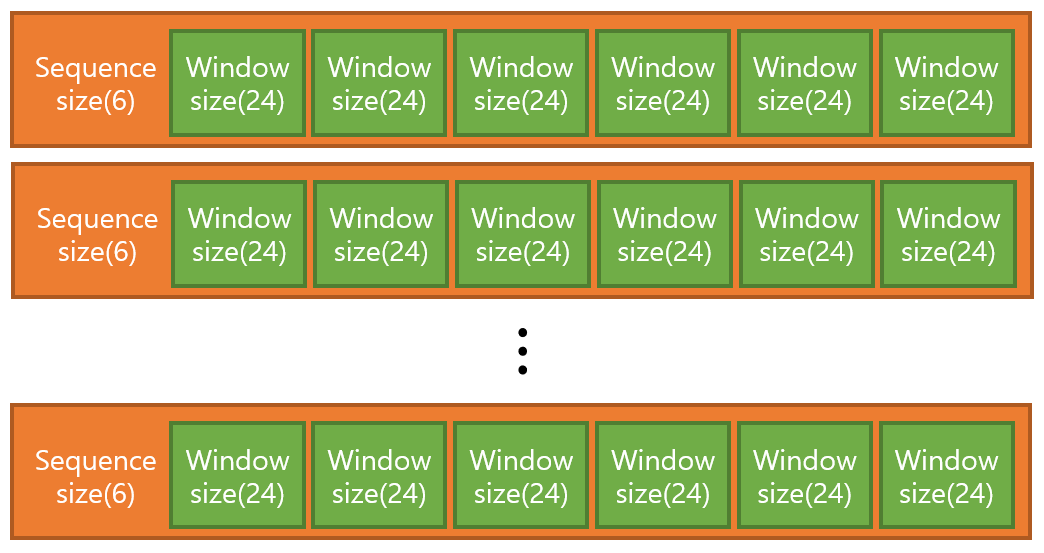

In [ ]:
lstm_seq = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/lstm_seq.npy')
test_seq = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/test_seq.npy')
test_labels = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/test_labels.npy')

In [ ]:
print('Train 데이터 Shape: ', lstm_seq.shape)
print('Test 데이터 Shape: ', test_seq.shape)
print('Test 데이터에서 낙상 수: ', sum(test_labels == 1))

Train 데이터 Shape:  (77732, 6, 24)
Test 데이터 Shape:  (12022, 6, 24, 1)
Test 데이터에서 낙상 수:  90


## 2.2. 데이터 전처리


### [1] 하나의 Sequence(6x24)에 대해서 5가지 통계값 사용 (N, 5)
X: 하나의 Sequence에 대해 skew, kurtosis, mean, max, std를 구함  
Y: VAE-LSTM과 동일 label 사용

In [ ]:
flatten_train_data = lstm_seq.reshape(-1,lstm_seq.shape[1]*lstm_seq.shape[2])
flatten_test_data = test_seq.reshape(-1,test_seq.shape[1]*test_seq.shape[2])

train_data1 = np.vstack((skew(flatten_train_data, axis = 1), kurtosis(flatten_train_data, axis = 1), np.mean(np.abs(flatten_train_data), axis = 1), np.std(flatten_train_data, axis = 1), np.max(np.abs(flatten_train_data), axis = 1))).T
test_data1 = np.vstack((skew(flatten_test_data, axis = 1), kurtosis(flatten_test_data, axis = 1), np.mean(np.abs(flatten_test_data), axis = 1), np.std(flatten_test_data, axis = 1), np.max(np.abs(flatten_test_data), axis = 1))).T
test_labels1 = test_labels

### [2] Window size(24)의 데이터 중 Max 값 사용 (N, 6)
X: Sequence 안의 6개의 Window size(24)만큼의 데이터 각각에 대해 Max값 사용  
Y: VAE-LSTM과 동일 label 사용

In [ ]:
train_data2 = np.abs(lstm_seq).max(axis=2) 
test_data2 = np.abs(np.squeeze(test_seq, axis=3)).max(axis=2)
test_labels2 = test_labels

### [3] 단일 시점의 데이터 사용 (N, 1)
X: 시계열적 요소를 고려하지 않고 단일 시점의 값 사용  
Y: 단일 시점의 label 사용

In [ ]:
result = dict(np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/NAB-known-anomaly/fall_data.npz', allow_pickle=True))
train_data3 = result['training'].reshape(-1,1)
test_data3 = result['test'].reshape(-1,1)
idx_anomaly_test = result['idx_anomaly_test']
test_labels3 = [1 if i in idx_anomaly_test else 0 for i in range(len(test_data3))]

# 3. Anomaly detection

In [ ]:
# 평가 결과 출력 함수(Confusion matrix, Accuracy, Precision, Recall, F1 score)
def print_result(y_true, y_pred):
    print('Confusion matrix')
    print(confusion_matrix(y_true, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))
    print('TP: ', tp)
    print('FP: ', fp)
    print('FN: ', fn)

## 3.1. Isolation Forest

### 3.1.1. 데이터 [1] 사용

In [ ]:
clf_IF1 = IsolationForest(max_samples=100, contamination = 0.1, bootstrap=True, random_state=42)
clf_IF1.fit(train_data1)
y_pred_test_IF1 = clf_IF1.predict(test_data1)
y_pred_test_IF1 = np.array([0 if i == 1 else 1 for i in y_pred_test_IF1])
print_result(test_labels1, y_pred_test_IF1)

Confusion matrix
[[11214   718]
 [    0    90]]
Accuracy:  0.9402761603726502
Precision:  0.11138613861386139
Recall:  1.0
F1:  0.20044543429844097
TP:  90
FP:  718
FN:  0


### 3.1.2. 데이터 [2] 사용

In [ ]:
clf_IF2 = IsolationForest(max_samples=100, contamination = 0.1, bootstrap=True, random_state=42)
clf_IF2.fit(train_data2)
y_pred_test_IF2 = clf_IF2.predict(test_data2)
y_pred_test_IF2 = np.array([0 if i == 1 else 1 for i in y_pred_test_IF2])
print_result(test_labels2, y_pred_test_IF2)

Confusion matrix
[[11211   721]
 [    0    90]]
Accuracy:  0.9400266178672434
Precision:  0.11097410604192355
Recall:  1.0
F1:  0.1997780244173141
TP:  90
FP:  721
FN:  0


### 3.1.3. 데이터 [3] 사용

In [ ]:
clf_IF3 = IsolationForest(max_samples=100, contamination = 0.1, bootstrap=True, random_state=42)
clf_IF3.fit(train_data3)
y_pred_test_IF3 = clf_IF3.predict(test_data3)
y_pred_test_IF3 = np.array([0 if i == 1 else 1 for i in y_pred_test_IF3])
print_result(test_labels3, y_pred_test_IF3)

Confusion matrix
[[10749  1369]
 [    3    46]]
Accuracy:  0.887235966137914
Precision:  0.03250883392226148
Recall:  0.9387755102040817
F1:  0.06284153005464481
TP:  46
FP:  1369
FN:  3


## 3.2. OCSVM

### 3.2.1. 데이터 [1] 사용

In [ ]:
clf_ocsvm1 = OneClassSVM(gamma='auto').fit(train_data1)
y_pred_test_ocsvm1 = clf_ocsvm1.predict(test_data1)
y_pred_test_ocsvm1 = np.array([0 if i == 1 else 1 for i in y_pred_test_ocsvm1])
print_result(test_labels1, y_pred_test_ocsvm1)

Confusion matrix
[[5821 6111]
 [   0   90]]
Accuracy:  0.49168191648644155
Precision:  0.01451378809869376
Recall:  1.0
F1:  0.028612303290414875
TP:  90
FP:  6111
FN:  0


### 3.2.2. 데이터 [2] 사용

In [ ]:
clf_ocsvm2 = OneClassSVM(gamma='auto').fit(train_data2)
y_pred_test_ocsvm2 = clf_ocsvm2.predict(test_data2)
y_pred_test_ocsvm2 = np.array([0 if i == 1 else 1 for i in y_pred_test_ocsvm2])
print_result(test_labels2, y_pred_test_ocsvm2)

Confusion matrix
[[5268 6664]
 [   0   90]]
Accuracy:  0.44568291465646315
Precision:  0.013325436778205508
Recall:  1.0
F1:  0.026300409117475165
TP:  90
FP:  6664
FN:  0


### 3.2.3. 데이터 [3] 사용

In [ ]:
clf_ocsvm3 = OneClassSVM(gamma='auto').fit(train_data3)
y_pred_test_ocsvm3 = clf_ocsvm3.predict(test_data3)
y_pred_test_ocsvm3 = np.array([0 if i == 1 else 1 for i in y_pred_test_ocsvm3])
print_result(test_labels3, y_pred_test_ocsvm3)

Confusion matrix
[[6101 6017]
 [   1   48]]
Accuracy:  0.5053834141530369
Precision:  0.007914262159934049
Recall:  0.9795918367346939
F1:  0.015701668302257117
TP:  48
FP:  6017
FN:  1
